In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import fsspec
import requests
import aiohttp
import nc_time_axis

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_37075/3986769523.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


#### this is the dataset we want to use

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


#### the following is basically the same as the previous one, but offers a convenient way to see the number of possible values of each column

In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


#### we usually use the df.query to filter the data we want

In [5]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'historical'")

# df_ta_ncar.experiment_id.unique()
df_ta_ncar


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61655,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61862,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
62691,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
63131,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
63266,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
64615,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311
64914,CMIP,NCAR,CESM2,historical,r7i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...,NaN,20190311
64983,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...,NaN,20190311
66341,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313


In [6]:

"""
Another way to do this:
query = dict(
    experiment_id=['abrupt-4xCO2','piControl'], # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',                            # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=['tas', 'rsut','rsdt','rlut'],  # choose to look at near-surface air temperature (tas) as our variable
    member_id = 'r1i1p1f1',                     # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()
"""

'\nAnother way to do this:\nquery = dict(\n    experiment_id=[\'abrupt-4xCO2\',\'piControl\'], # pick the `abrupt-4xCO2` and `piControl` forcing experiments\n    table_id=\'Amon\',                            # choose to look at atmospheric variables (A) saved at monthly resolution (mon)\n    variable_id=[\'tas\', \'rsut\',\'rsdt\',\'rlut\'],  # choose to look at near-surface air temperature (tas) as our variable\n    member_id = \'r1i1p1f1\',                     # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)\n)\n\ncol_subset = col.search(require_all_on=["source_id"], **query)\ncol_subset.df.groupby("source_id")[\n    ["experiment_id", "variable_id", "table_id"]\n].nunique()\n'

#### Then we pick one dataset and open it with xarray.<br>
Xarray in my opinion is an upgraded version of pandas. For example, in the dataset below, we have longitude and latitude, and each of them has several values (in our case it is one), such as temperature, pressure, etc. If we are using pandas, we must use multi-indices, or store list in each entry. In comparison, xarray is much more organized. It firstly shows how we divided our coordinates, and then, if we want to see some specific values, just use .squeeze

In [7]:
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_ncar.zstore.values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/a7278f6d-6a1b-4050-8f06-a8033604736a...
    version_id:             v20190514

In [8]:
# ds.tas.sel(time='1950-01').squeeze().plot.contourf()
# plt.figure()


#### And xarray also has the built-in plot function, which is better than pandas, which I need to convert to numpy array first.<br>
And we do need to do some settings before plotting, as shown below

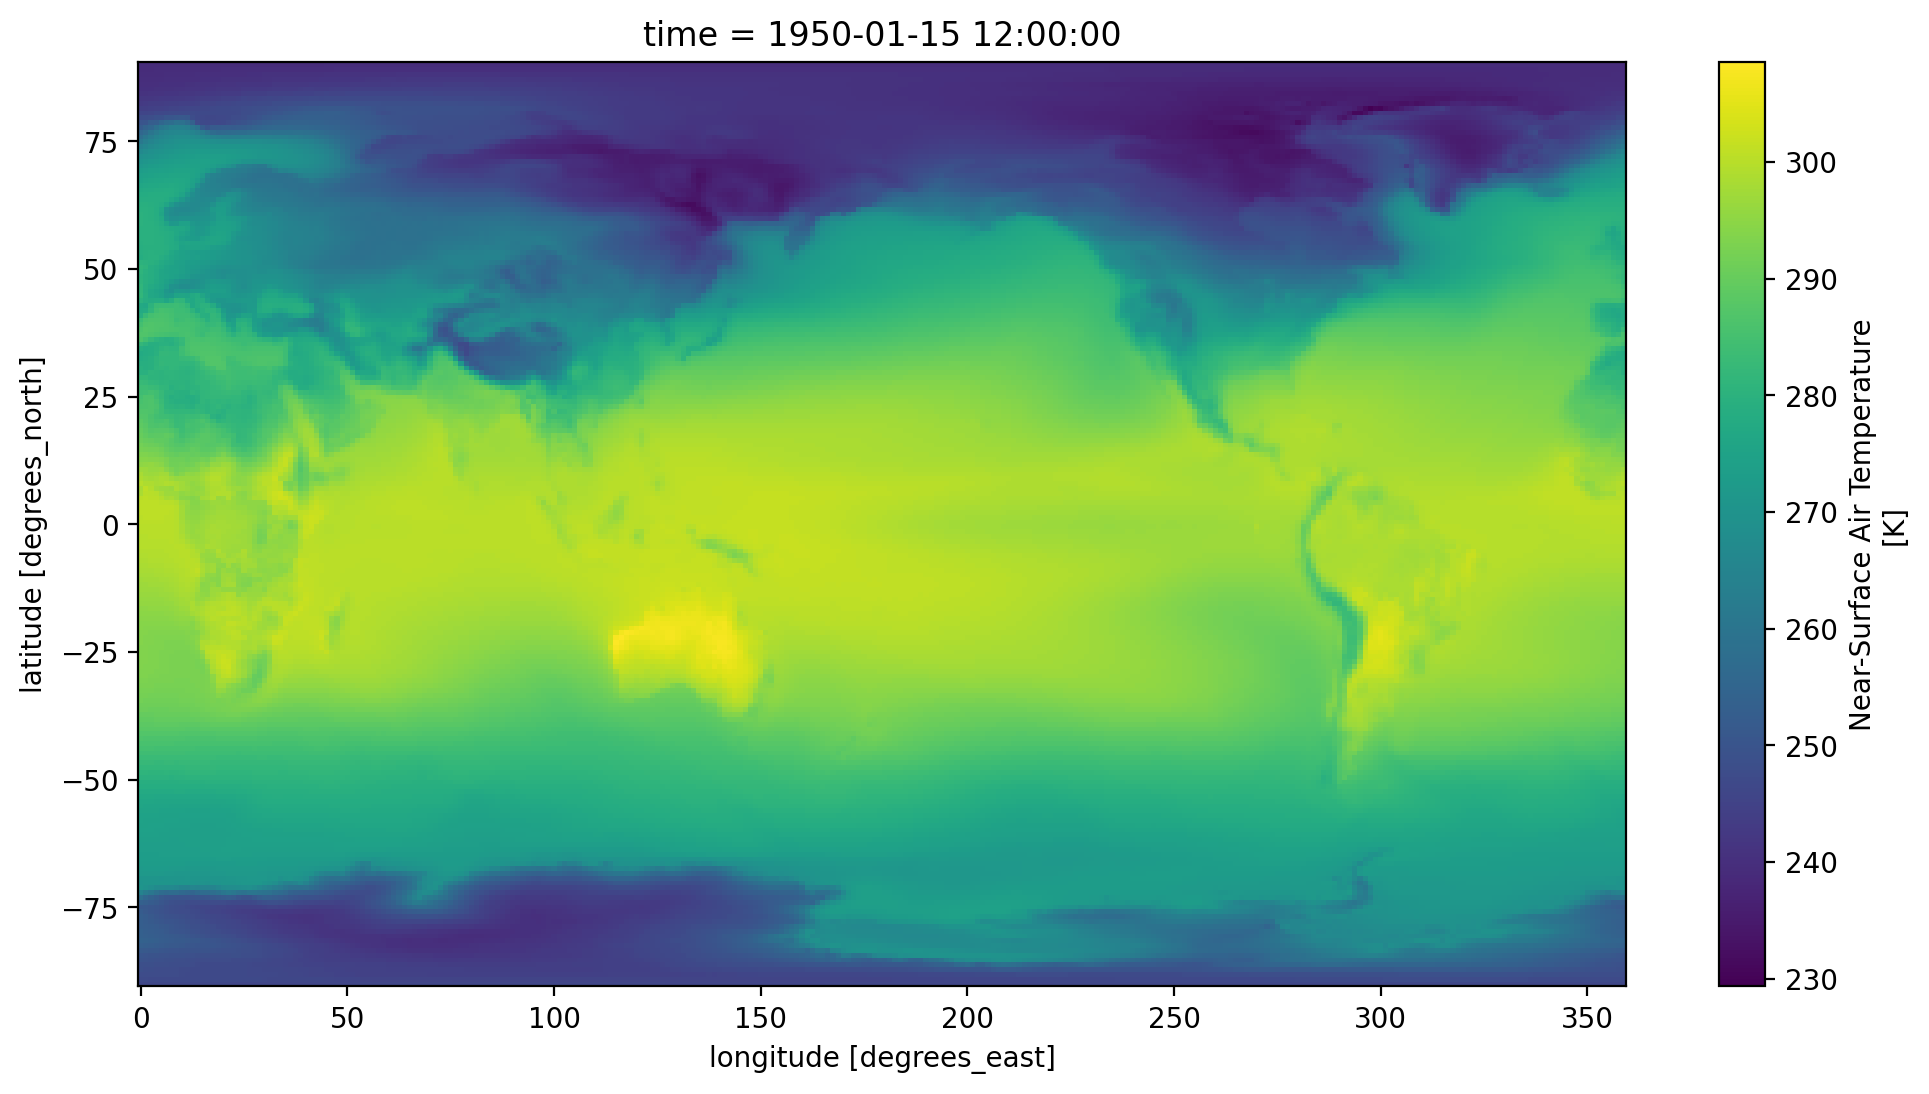

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
ds.tas.sel(time='1950-01').squeeze().plot()

1980 months, 96 latitude, 144 longitude.

In [10]:
ds.tas.shape

(1980, 192, 288)

#### So far so good, but I did find some problem with the sample script<br>
This is the area of earth, data provided by pangeo's big dataset


In [11]:
# areacella == Grid-Cell Area for Atmospheric Grid Variables
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
df_area

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
58638,CMIP,NCAR,CESM2,historical,r1i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61483,CMIP,NCAR,CESM2,historical,r5i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
61561,CMIP,NCAR,CESM2,historical,r4i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61574,CMIP,NCAR,CESM2,historical,r3i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
61928,CMIP,NCAR,CESM2,historical,r6i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
63082,CMIP,NCAR,CESM2,historical,r2i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
64031,CMIP,NCAR,CESM2,historical,r7i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...,NaN,20190311
65388,CMIP,NCAR,CESM2,historical,r9i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...,NaN,20190311
65872,CMIP,NCAR,CESM2,historical,r8i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311
66386,CMIP,NCAR,CESM2,historical,r10i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313


In [12]:

ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
ds_area

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            areacella
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/96455df2-979e-4cd4-8521-ddf307c6bc4a
    version_id:             v20190514

In [13]:
df_area.zstore.values[-1]

'gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/fx/areacella/gn/v20190514/'

### The dimensions does not match, and I tries several ways to solve this problem.<br> 
The basic algorithm is that denote the temperature for each area as temp_i, each area to be area_i $$\frac{\sum_i temp_i * area_i}{\sum_i area_i}$$<br>
which is weighted average. However, the two datasets has different number of lat and lon divided

### Thus I tried to use another algorithm.<br>
### Firstly, I directly multipy temperatre and area component-wisely, and then take sum. Then divide them by the number of entries. (for example, if temp * area resulted in m*n matrix, then I take the sum of the entries and then divide it by mn)
### Then do the same thing to area

In [14]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# temp_avg = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / ((ds.tas * ds_area.areacella).shape[-1] * (ds.tas * ds_area.areacella).shape[-2])
# area_avg = ds_area.areacella.sum(dim=['lon', 'lat']) / (ds_area.areacella.shape[-1] * ds_area.areacella.shape[-2])
# ta_timeseries = temp_avg / area_avg
ta_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [15]:
%time ta_timeseries.load()

CPU times: user 1.16 s, sys: 486 ms, total: 1.64 s
Wall time: 5.7 s


<xarray.DataArray (time: 1980)>
array([285.3431 , 285.51422, 286.22678, ..., 288.4625 , 287.72174,
       287.05515], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [16]:
# ta_timeseries['time'][0]
# ta_timeseries['time'] = ta_timeseries.indexes['time'].to_datetimeindex()
# ta_timeseries['time'][0]

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

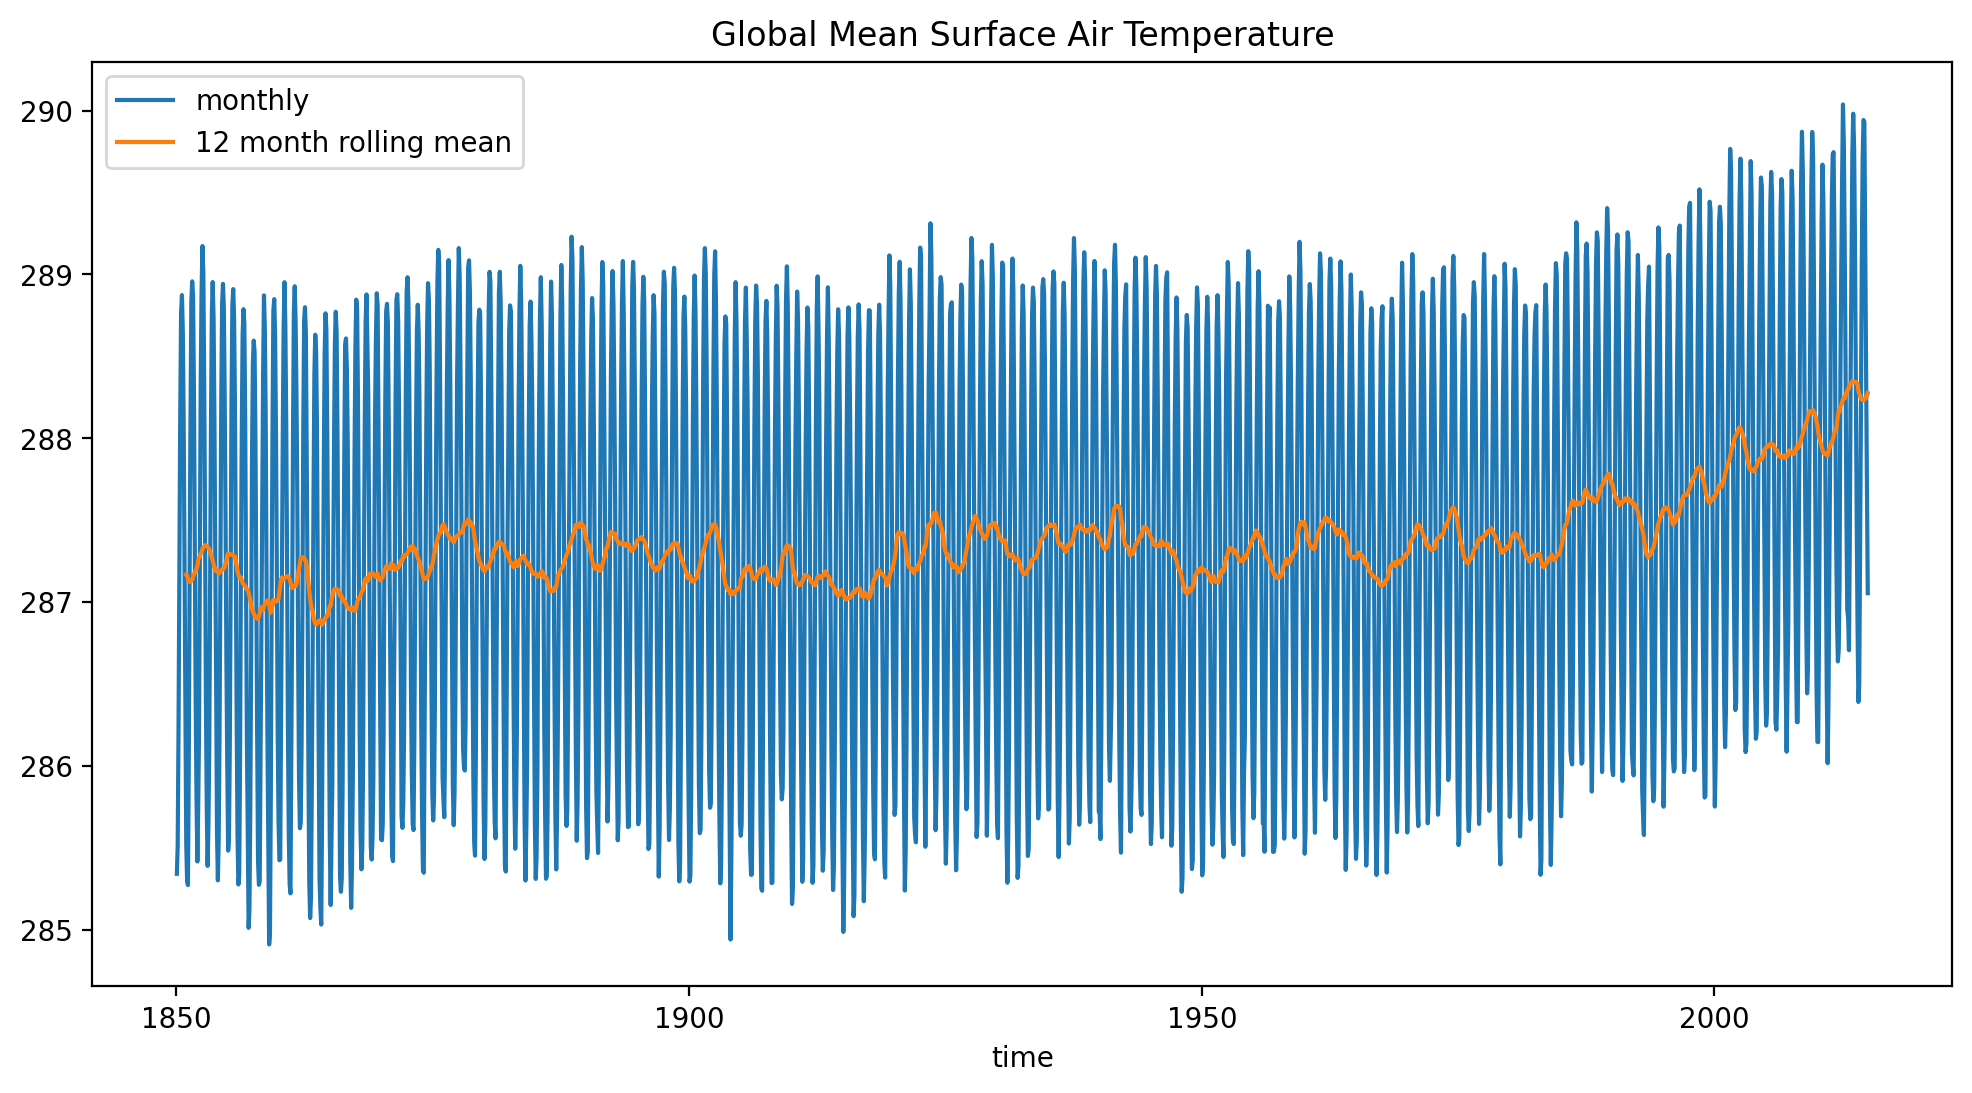

In [17]:

# ta_timeseries[:100].plot(label='monthly')
# ta_timeseries[:100].rolling(time=12).mean().plot(label='12 month rolling mean')
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

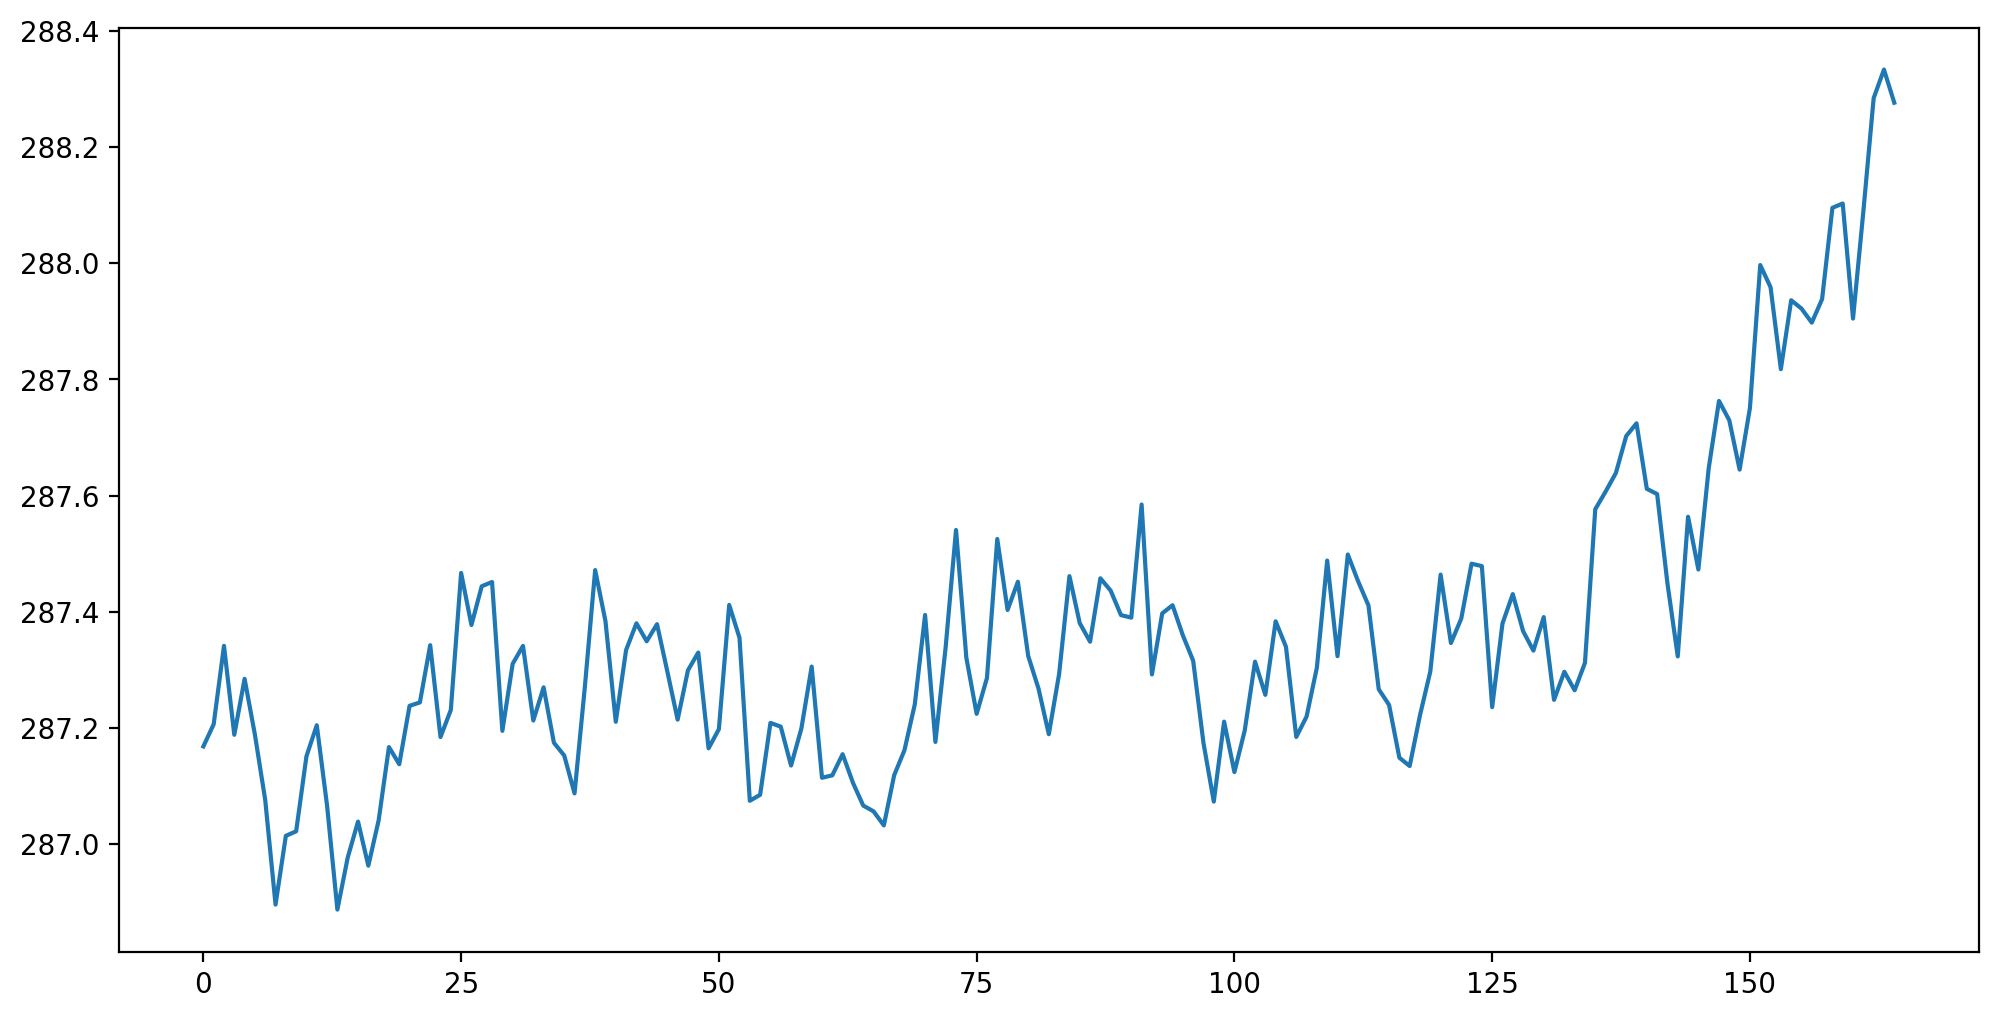

In [18]:
array_tas_ts = np.array(ta_timeseries)
year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
plt.plot(year_tas_ts)
plt.show()

In [23]:
len(array_tas_ts)

1980

Optimized C: 515.00
Optimized F: 10.00
Optimized lambda: 0.03


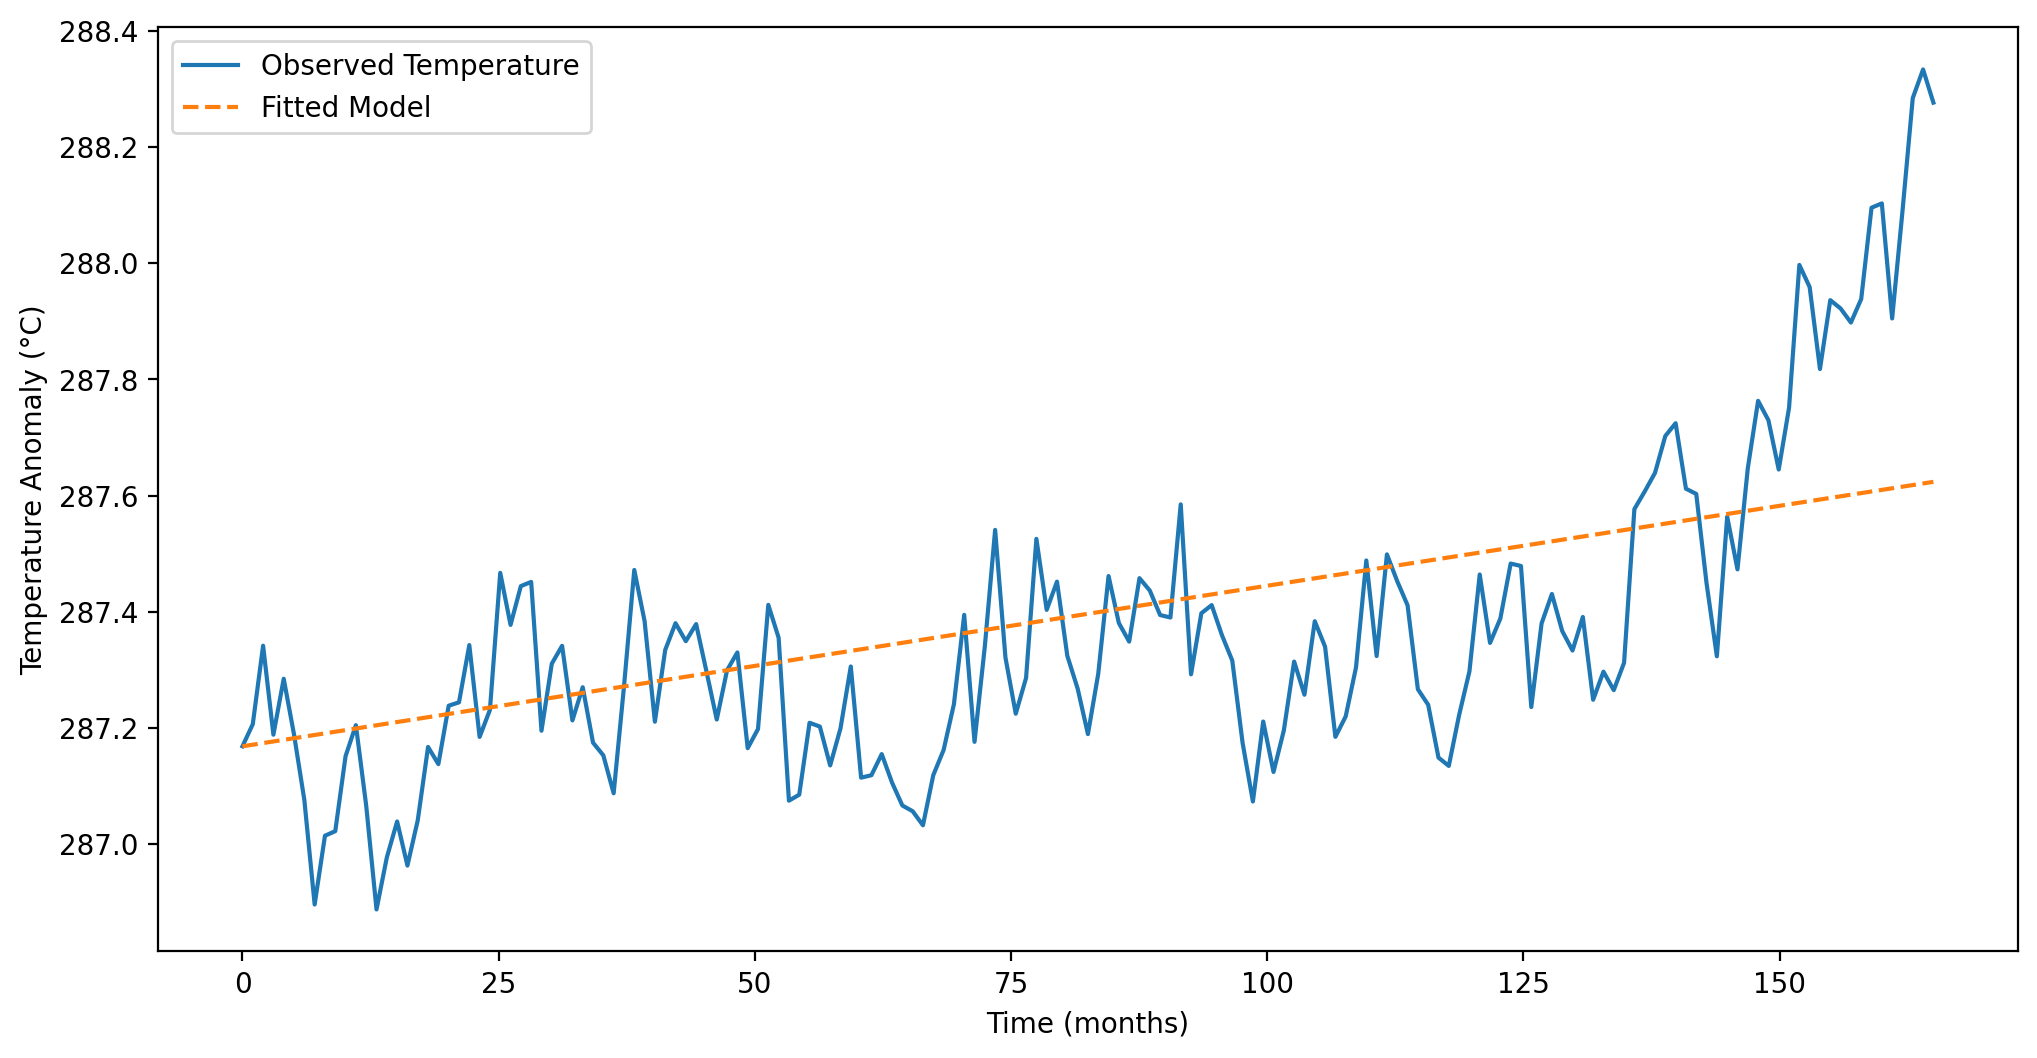

In [20]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the simple climate model ODE
def climate_model(T, t, C, F, lambda_param):
    dTdt = (F - lambda_param * T) / C
    return dTdt

# Define the objective function to minimize with additional checks
def objective_function(params, t, T_obs):
    C, F, lambda_param = params
    if C <= 0 or lambda_param <= 0:
        return np.inf  # Ensure positive parameters to prevent unphysical behavior
    
    T0 = T_obs[0]  # initial temperature condition
    T_model = odeint(climate_model, T0, t, args=(C, F, lambda_param)).flatten()
    
    # Calculate weighted cost function
    diff = T_model - T_obs
    weighted_cost = np.sum((diff**2) / (1 + np.abs(T_obs)))
    
    return weighted_cost

# Load or create your time series data (replace with actual data)
t = np.linspace(0, 165, 165)  # Time in months
T_obs = year_tas_ts  # Ensure T_obs is your input data array

# Initial parameter guesses for C, F, lambda
initial_params = [515, 10, 0.05]  # Adjust initial guesses for better convergence

# Add parameter bounds for stability
bounds = [(1, 1000), (0.1, 10), (0.01, 5)]  # Reasonable bounds for C, F, and lambda

# Optimize the parameters with bounds
result = minimize(objective_function, initial_params, args=(t, T_obs), method='L-BFGS-B', bounds=bounds)

# Extract optimized parameters
C_opt, F_opt, lambda_opt = result.x

# Print the results
print(f"Optimized C: {C_opt:.2f}")
print(f"Optimized F: {F_opt:.2f}")
print(f"Optimized lambda: {lambda_opt:.2f}")

# Plot the observed and fitted model
T_model = odeint(climate_model, T_obs[0], t, args=(C_opt, F_opt, lambda_opt)).flatten()
plt.plot(t, T_obs, label='Observed Temperature')
plt.plot(t, T_model, label='Fitted Model', linestyle='--')
plt.xlabel('Time (months)')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()



Optimized C: 515.00
Optimized F: 10.00
Optimized lambda: 0.03


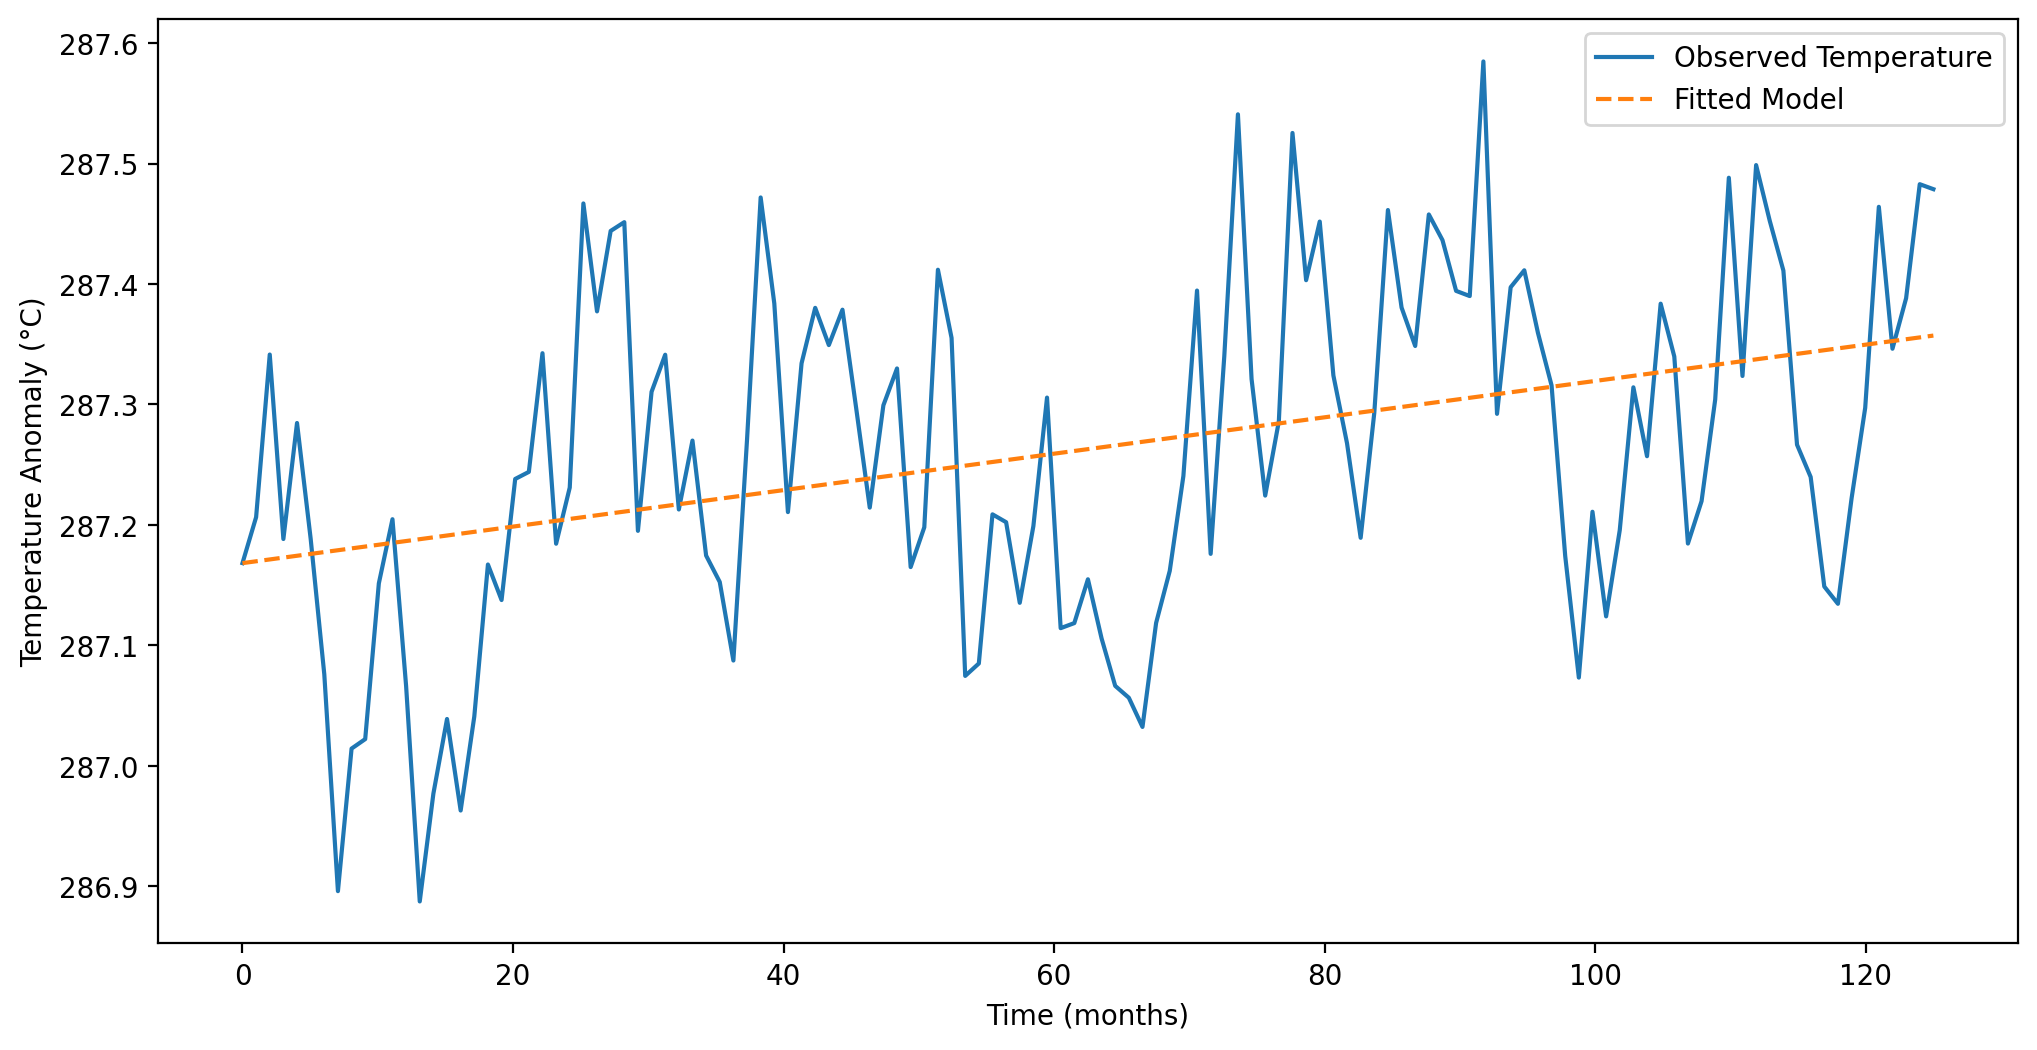

Optimized C: 310.96
Optimized F: 10.00
Optimized lambda: 0.01


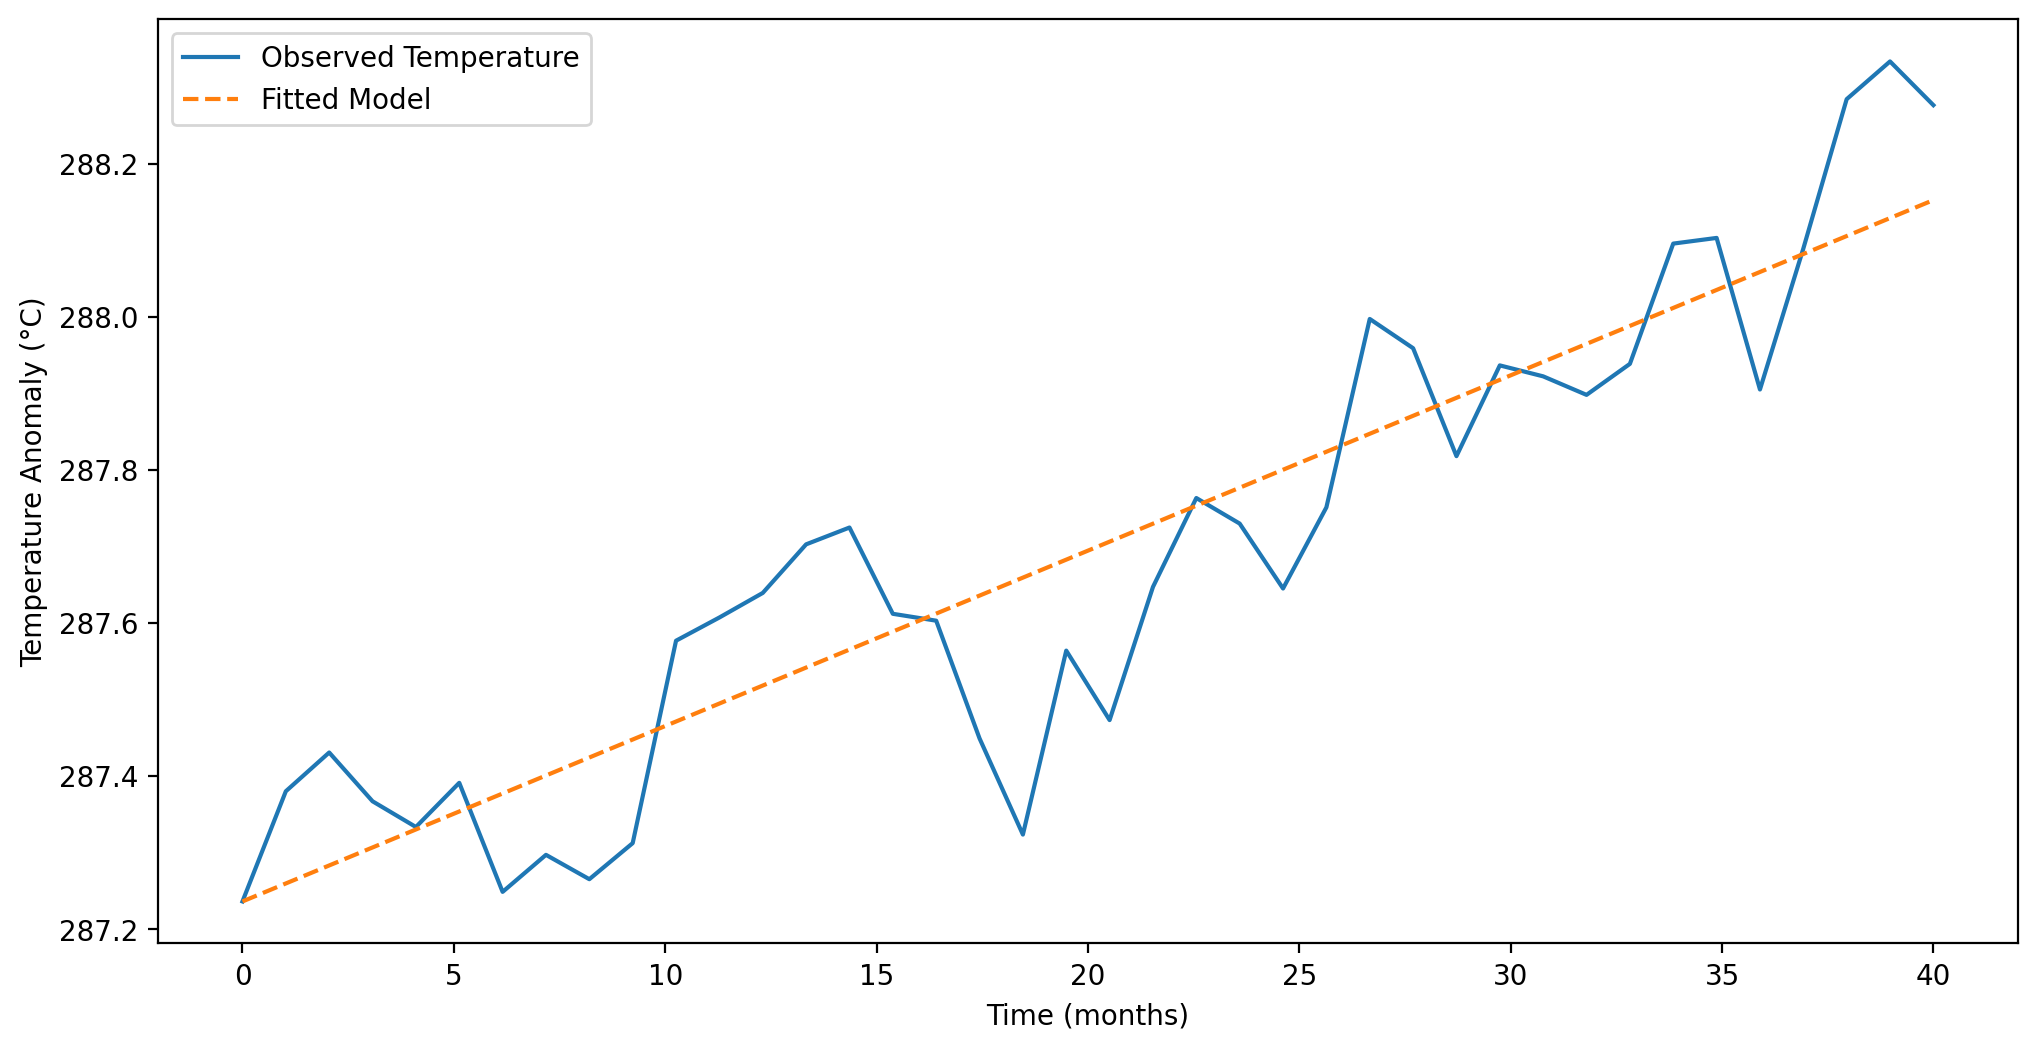

In [21]:
# Load or create your time series data (replace with actual data)
t = np.linspace(0, 125, 125)  # Time in months
T_obs = year_tas_ts[:125]  # Ensure T_obs is your input data array
# Optimize the parameters with bounds
result = minimize(objective_function, initial_params, args=(t, T_obs), method='L-BFGS-B', bounds=bounds)
# Extract optimized parameters
C_opt, F_opt, lambda_opt = result.x
# Print the results
print(f"Optimized C: {C_opt:.2f}")
print(f"Optimized F: {F_opt:.2f}")
print(f"Optimized lambda: {lambda_opt:.2f}")
# Plot the observed and fitted model
T_model = odeint(climate_model, T_obs[0], t, args=(C_opt, F_opt, lambda_opt)).flatten()
plt.plot(t, T_obs, label='Observed Temperature')
plt.plot(t, T_model, label='Fitted Model', linestyle='--')
plt.xlabel('Time (months)')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()



# Load or create your time series data (replace with actual data)
t = np.linspace(0, 40, 40)  # Time in months
T_obs = year_tas_ts[125:]  # Ensure T_obs is your input data array
# Optimize the parameters with bounds
result = minimize(objective_function, initial_params, args=(t, T_obs), method='L-BFGS-B', bounds=bounds)
# Extract optimized parameters
C_opt, F_opt, lambda_opt = result.x
# Print the results
print(f"Optimized C: {C_opt:.2f}")
print(f"Optimized F: {F_opt:.2f}")
print(f"Optimized lambda: {lambda_opt:.2f}")
# Plot the observed and fitted model
T_model = odeint(climate_model, T_obs[0], t, args=(C_opt, F_opt, lambda_opt)).flatten()
plt.plot(t, T_obs, label='Observed Temperature')
plt.plot(t, T_model, label='Fitted Model', linestyle='--')
plt.xlabel('Time (months)')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

Optimized C: 515.13
Optimized F: 10.00
Optimized lambda: 0.03


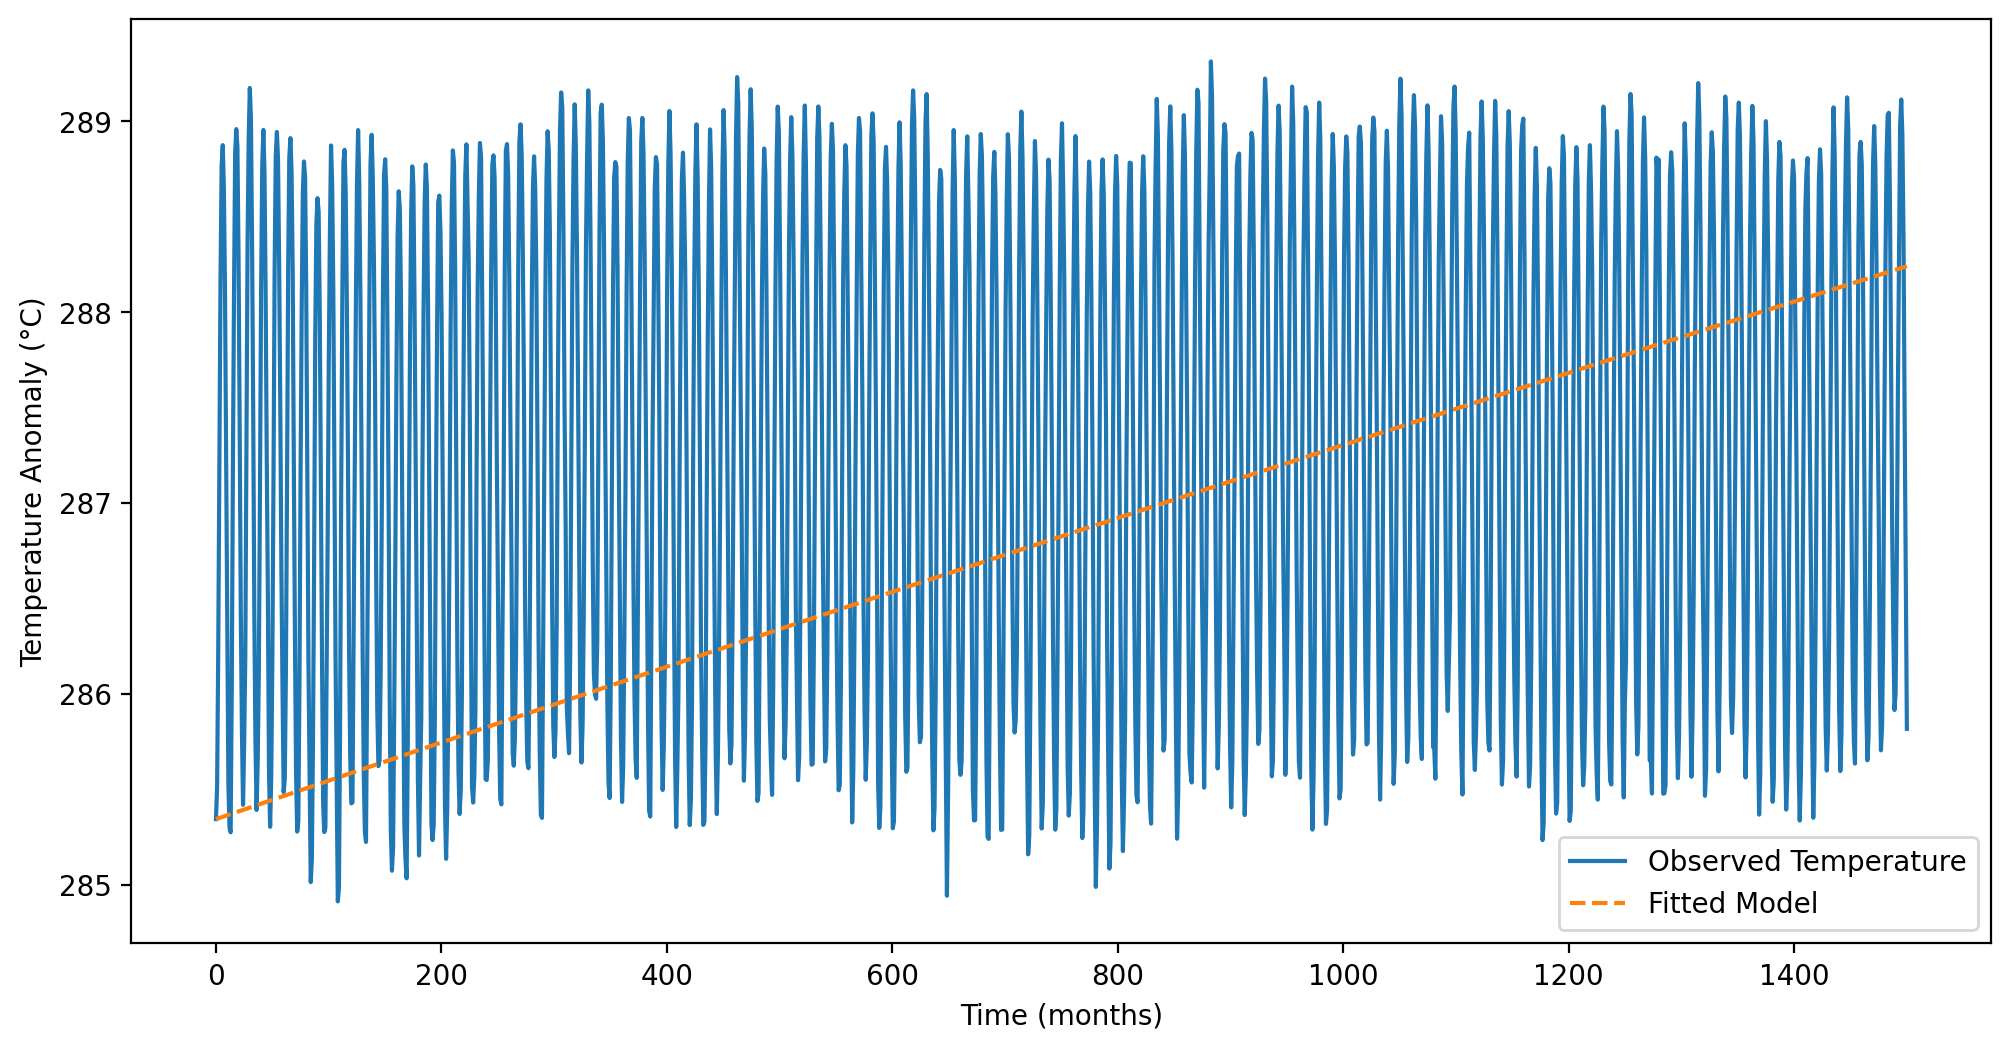

Optimized C: 515.04
Optimized F: 10.00
Optimized lambda: 0.02


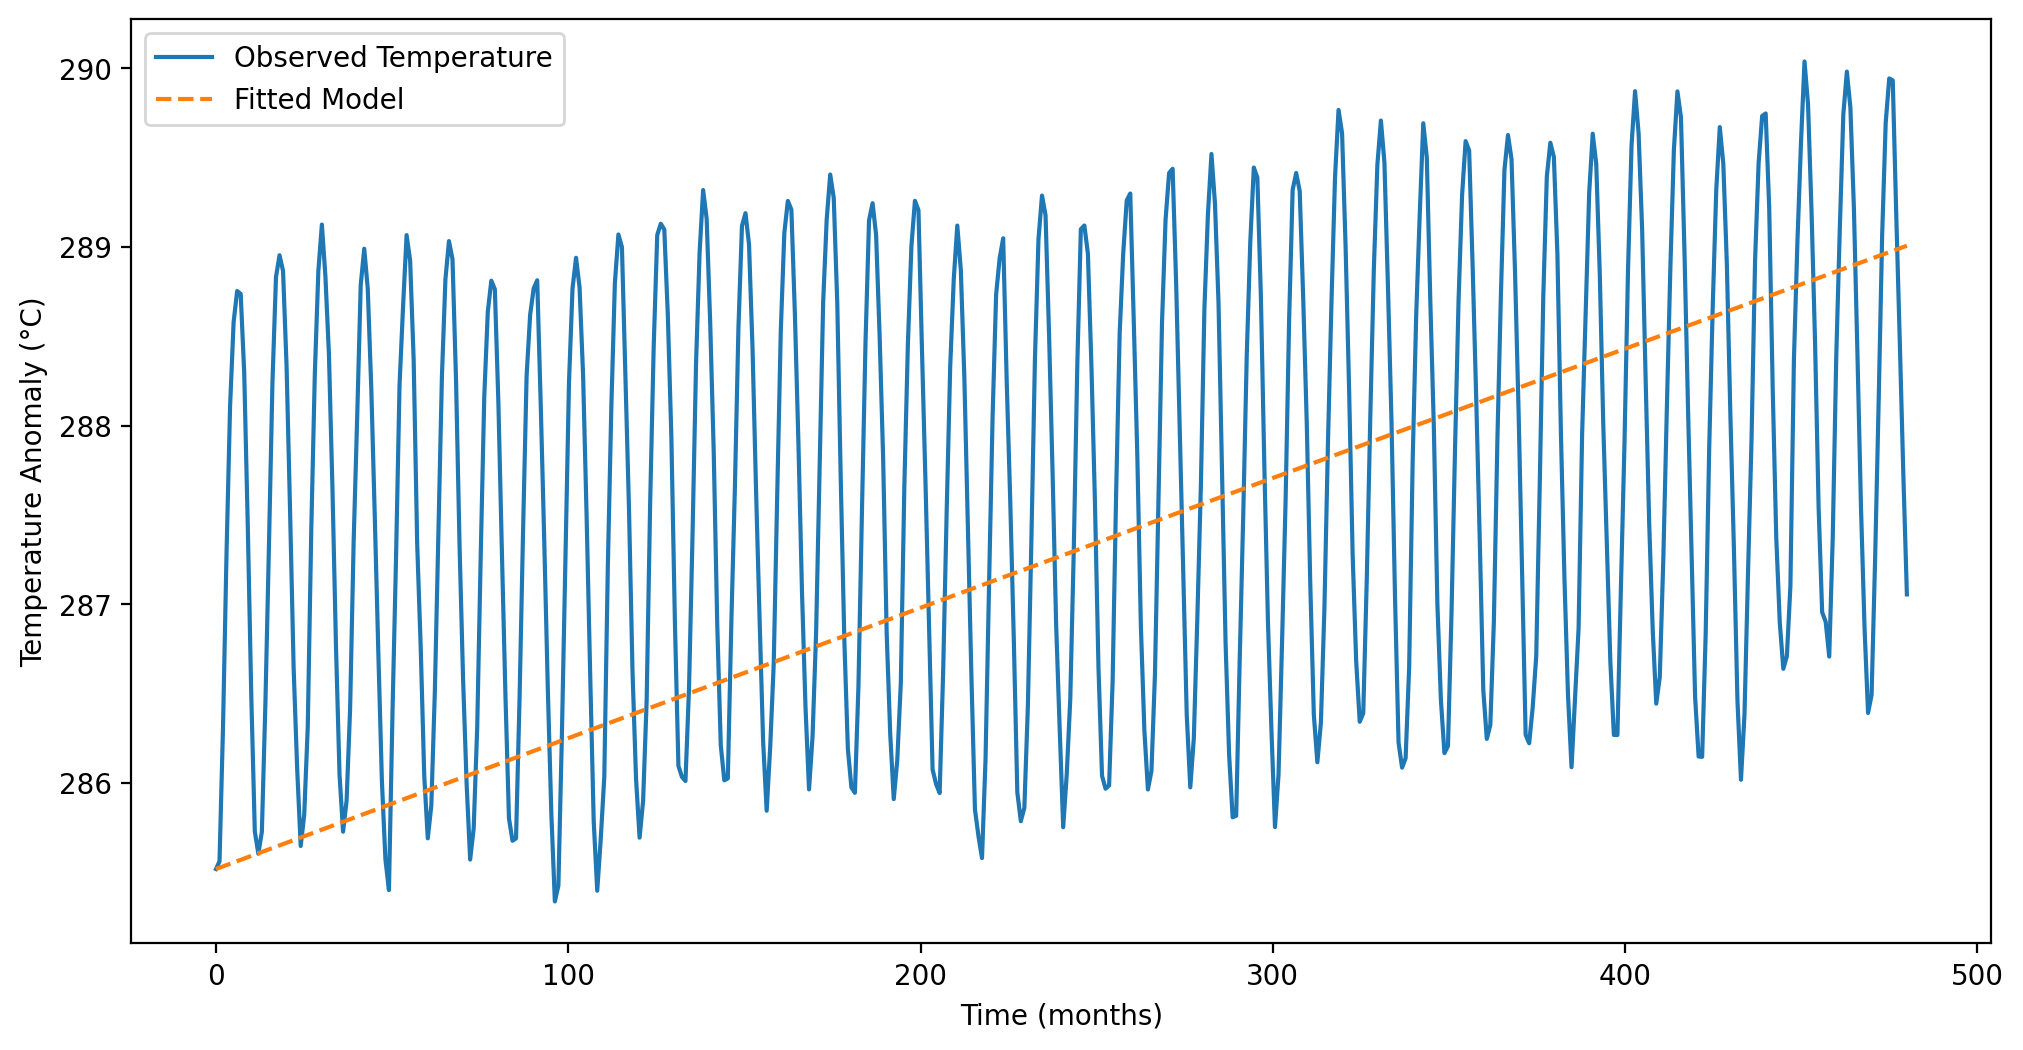

In [22]:
# Load or create your time series data (replace with actual data)
t = np.linspace(0, 1500, 1500)  # Time in months
T_obs = array_tas_ts[:1500]  # Ensure T_obs is your input data array
# Optimize the parameters with bounds
result = minimize(objective_function, initial_params, args=(t, T_obs), method='L-BFGS-B', bounds=bounds)
# Extract optimized parameters
C_opt, F_opt, lambda_opt = result.x
# Print the results
print(f"Optimized C: {C_opt:.2f}")
print(f"Optimized F: {F_opt:.2f}")
print(f"Optimized lambda: {lambda_opt:.2f}")
# Plot the observed and fitted model
T_model = odeint(climate_model, T_obs[0], t, args=(C_opt, F_opt, lambda_opt)).flatten()
plt.plot(t, T_obs, label='Observed Temperature')
plt.plot(t, T_model, label='Fitted Model', linestyle='--')
plt.xlabel('Time (months)')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()



# Load or create your time series data (replace with actual data)
t = np.linspace(0, 480, 480)  # Time in months
T_obs = array_tas_ts[1500:]  # Ensure T_obs is your input data array
# Optimize the parameters with bounds
result = minimize(objective_function, initial_params, args=(t, T_obs), method='L-BFGS-B', bounds=bounds)
# Extract optimized parameters
C_opt, F_opt, lambda_opt = result.x
# Print the results
print(f"Optimized C: {C_opt:.2f}")
print(f"Optimized F: {F_opt:.2f}")
print(f"Optimized lambda: {lambda_opt:.2f}")
# Plot the observed and fitted model
T_model = odeint(climate_model, T_obs[0], t, args=(C_opt, F_opt, lambda_opt)).flatten()
plt.plot(t, T_obs, label='Observed Temperature')
plt.plot(t, T_model, label='Fitted Model', linestyle='--')
plt.xlabel('Time (months)')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()